## Comparison of convolution-based and fft-based filtering

In [141]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import norm
from scipy.fft import fft, ifft
import bottleneck as bn
%matplotlib inline
plt.rcParams.update({'font.size': 8})

In [142]:
def cdf_diff(sig:np.ndarray, loc1:float, scale1:float, loc2:float, scale2:float):
    'Difference of 2 Gaussian CDFs'
    Nsig=len(sig)
    Nrfft=Nsig//2
    xarr=np.linspace(0,Nrfft/(2*Nrfft),Nrfft)
    WIN=norm.cdf(xarr,loc=loc1,scale=scale1)-norm.cdf(xarr,loc=loc2,scale=scale2)
    WIN=np.concatenate((WIN, np.array([WIN[-1],WIN[-1]]), np.flip(WIN[:-1])))
    sigfiltfft=np.real(ifft(WIN*fft(sig)))/np.sqrt(2*np.pi)
    FSINC=WIN*fft(sinc(Nsig))
    filt=np.real(ifft(FSINC))
    filt=filt/np.sum(np.abs(filt))
    sigfiltconv=np.convolve(sig,filt,mode='same')
    return sig, sigfiltconv, sigfiltfft, WIN

In [143]:
def gauss(filtlen:int, loc:float, scale:float):
    'Gaussian window function'
    assert np.mod(filtlen,1) == 0, 'Length of signal must be odd'
    Nrfft=filtlen//2
    xarr=np.linspace(0,Nrfft/(2*Nrfft),Nrfft)
    WIN=norm.pdf(xarr,loc=loc,scale=scale)
    WIN=np.concatenate((WIN, np.array([WIN[-1],WIN[-1]]), np.flip(WIN[:-1])))
    return WIN

In [167]:
def sine_nthroot(filtlen:int, nroot:int=5):
    'Nth-root of sine window function'
    assert np.mod(filtlen,1) == 0, 'Length of signal must be odd'
    Nrfft=filtlen//2
    win=np.sin(np.linspace(0,np.pi/2.,Nrfft))**(1/nroot)
    win=np.concatenate((win, np.array([win[-1],win[-1]]), np.flip(win[:-1])))
    return win

In [163]:
def cos_nthroot(filtlen:int, nroot:int=5):
    'Nth-root of cosine window function'
    assert np.mod(filtlen,1) == 0, 'Length of signal must be odd'
    Nrfft=filtlen//2
    win=np.cos(np.linspace(0,np.pi/2.,Nrfft))**(1/nroot)
    win=np.concatenate((win, np.array([win[-1],win[-1]]), np.flip(win[:-1])))
    return win

In [144]:
def applyConvFilt(sig:np.ndarray,fftwin:np.ndarray,threshold:float=0.95):
  FSINC=fftwin*fft(sinc(len(sig)))
  filt=np.real(ifft(FSINC))
  #--- get cumulative energy away from the peak of sinc
  Esym=np.cumsum(2*np.abs(filt[len(filt)//2:])); Esym-=filt[len(filt)//2]
  Esym=(Esym/Esym[-1])
  idx=np.argmax(Esym>=threshold)
  idxUsemin=len(filt)//2-idx
  idxUsemax=len(filt)//2+idx+1
  #--- crop at nearest peak
  DDfilt=np.convolve(filt,np.array([-1.,2.,-1.]),'same'); DDfilt=DDfilt[len(filt)//2:]; DDfilt[-2:]=0
  if DDfilt[1:].max() > 0:
    DDfilt[DDfilt<0]=0.
  else:
    DDfilt[:]=1.
  Esym=np.cumsum(2*np.abs(filt[len(filt)//2:])); Esym-=filt[len(filt)//2]
  Esym=(Esym/Esym[-1])
  idx=np.argmax(np.logical_and(Esym >= threshold, DDfilt >= 0))
  # idx=np.argmax(Esym >= threshold)
  idxUsemin=len(filt)//2-idx
  idxUsemax=len(filt)//2+idx+1
  #--- form the filter
  filt=filt[idxUsemin:idxUsemax]
  filt=filt/np.sum(np.abs(filt))
  sigfilt=np.convolve(sig,filt,mode='same')
  return sigfilt, filt

In [145]:
def applyFffFilt(sig:np.ndarray,fftwin:np.ndarray):
  return np.real(ifft(fftwin*fft(sig)))/np.sqrt(2*np.pi)

In [146]:
def sinc(Nsamp:int=1001):
  'Sinc filter'
  Nsamp=2*(Nsamp//2)+1
  xarr=np.linspace(-(Nsamp//2.25),Nsamp//2.25,Nsamp)
  fsinc=np.sinc(xarr)
  return fsinc

In [147]:
def genSweep(f0:float, f1:float, Nsamp:int):
  x=np.linspace(0,1,Nsamp)
  return np.concatenate((np.zeros(Nsamp//10),np.sin(np.pi/8+2.*np.pi*Nsamp*(f0*x+((f1-f0)/2.)*x**2)),np.zeros(Nsamp//20)))

In [148]:
def genSpike(k:int, Nsamp:int):
  x=np.zeros(Nsamp)
  x[k]=1
  return x

In [149]:
def plotResults(sig:np.ndarray, sigfiltconv:np.ndarray, sigfiltfft:np.ndarray, fftwin:np.ndarray, filtconv:np.ndarray):   
    fig, axs=plt.subplots(3, 3)
    fig.set_size_inches(30, 15)
    Nfreqxlabel=8; freqxlabelint=np.linspace(0,(Nfreqxlabel-1)/Nfreqxlabel,Nfreqxlabel)
    #freqxlabels=['$0$', r'$\frac{1}{8}$', r'$\frac{1}{4}$', r'$\frac{3}{8}$', r'$-\frac{1}{2}$', r'$-\frac{3}{8}$', r'$-\frac{1}{4}$', r'$-\frac{1}{8}$']
    freqxlabels=[str(np.round(x,2)) for x in np.fft.fftfreq(Nfreqxlabel,1)]
    #--- signal function 
    idxSigmin=0; idxSigmax=len(sig)-1
    xsig=np.arange(len(sig))
    axs[0,0].plot(xsig[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
    axs[0,0].set_xlabel('Sample')
    axs[0,0].set_xlim(xsig[idxSigmin],xsig[idxSigmax])
    axs[0,0].set_title(label=f'Input signal (length = {len(sig)})',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the input signal
    SIG=np.abs(fft(sig))
    freqs=np.arange(len(SIG))
    axs[0,1].fill_between(freqs,SIG,0.,color='maroon')
    axs[0,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,1].set_xlim(freqs.min(),freqs.max())
    axs[0,1].set_xticks(len(SIG)*freqxlabelint)
    axs[0,1].set_xticklabels(freqxlabels)
    axs[0,1].set_title(label='FFT amplitude of input signal',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the window function
    freqs=np.arange(len(fftwin))
    axs[0,2].fill_between(freqs,fftwin,0.,color='maroon')
    axs[0,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[0,2].set_ylim(fftwin.min(),fftwin.max())
    axs[0,2].set_xlim(freqs.min(),freqs.max())
    axs[0,2].set_xticks(len(fftwin)*freqxlabelint)
    axs[0,2].set_xticklabels(freqxlabels)
    axs[0,2].set_title(label='FFT window function',fontdict=None, loc='center', pad=None)
    #--- convolution-filtered signal
    idxmin=0; idxmax=len(sigfiltconv)-1
    # idxmin=50; idxmax=200
    xfilt=np.arange(len(sigfiltconv))
    axs[1,0].plot(xfilt[idxmin:idxmax],sigfiltconv[idxmin:idxmax])
    axs[1,0].set_xlabel('Sample')
    axs[1,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
    axs[1,0].set_title(label=f'Convolution-filtered (filt length = ({len(filtconv)})',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the convolution-filtered signal
    SIG_FILT=np.abs(fft(sigfiltconv))
    freqs=np.arange(len(SIG_FILT))
    axs[1,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
    axs[1,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[1,1].set_xlim(freqs.min(),freqs.max())
    axs[1,1].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[1,1].set_xticklabels(freqxlabels)
    axs[1,1].set_title(label='FFT amplitude of convolution-filtered signal',fontdict=None, loc='center', pad=None)
    #--- FFT phase of the convolution-filtered signal
    SIG_FILT=np.unwrap(np.angle((fft(sigfiltconv))))
    freqs=np.arange(len(SIG_FILT))
    axs[1,2].plot(freqs,SIG_FILT,color='maroon')
    axs[1,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[1,2].set_xlim(freqs.min(),freqs.max())
    axs[1,2].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[1,2].set_xticklabels(freqxlabels)
    axs[1,2].set_title(label='FFT phase of convolution-filtered signal',fontdict=None, loc='center', pad=None)
    #--- fft-filtered signal
    idxmin=0; idxmax=len(sigfiltfft)-1
    # idxmin=50; idxmax=200
    xfilt=np.arange(len(sigfiltfft))
    axs[2,0].plot(xfilt[idxmin:idxmax],sigfiltfft[idxmin:idxmax])
    axs[2,0].set_xlabel('Sample')
    axs[2,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
    axs[2,0].set_title(label='FFT-filtered',fontdict=None, loc='center', pad=None)
    #--- FFT amplitude of the fft-filtered signal
    SIG_FILT=np.abs(fft(sigfiltfft))
    freqs=np.arange(len(SIG_FILT))
    axs[2,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
    axs[2,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[2,1].set_xlim(freqs.min(),freqs.max())
    axs[2,1].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[2,1].set_xticklabels(freqxlabels)
    axs[2,1].set_title(label='FFT amplitude of fft-filtered signal',fontdict=None, loc='center', pad=None)
    #--- FFT phase of the fft-filtered signal
    SIG_FILT=np.unwrap(np.angle((fft(sigfiltfft))))
    freqs=np.arange(len(SIG_FILT))
    axs[2,2].plot(freqs,SIG_FILT,color='maroon')
    axs[2,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
    axs[2,2].set_xlim(freqs.min(),freqs.max())
    axs[2,2].set_xticks(len(SIG_FILT)*freqxlabelint)
    axs[2,2].set_xticklabels(freqxlabels)
    axs[2,2].set_title(label='FFT phase of fft-filtered signal',fontdict=None, loc='center', pad=None)
    #--- final adjsutments
    #fig.tight_layout()
    plt.show()

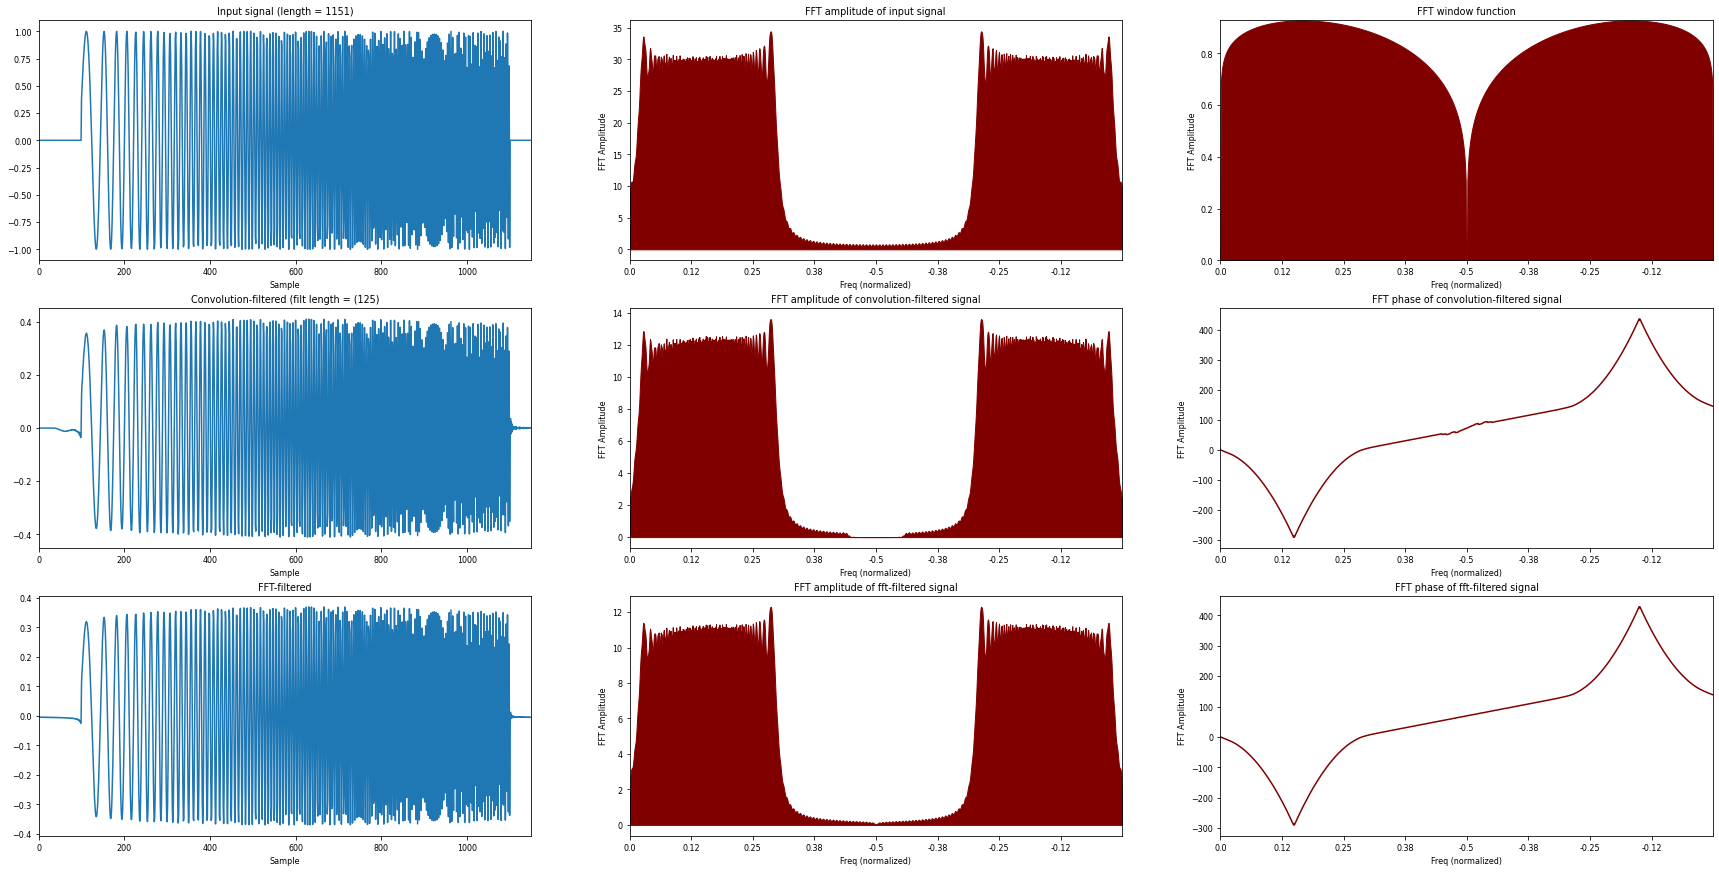

In [171]:
def main():
    mu_1=0.0;         mu_2=0.3
    sigma_1=0.35;     sigma_2=0.05
    #--- generate signal
    f0=0.015; f1=0.3; Nsamp=1001; signal=genSweep(f0,f1,Nsamp) # sweep
      # k=100; Nsamp=1001; signal=genSpike(k,Nsamp) # spike
      # Nsamp=1001; signal=sinc(Nsamp) # sinc
    #--- get fft window
    # sig, sigfiltconv, sigfiltfft, WIN = cdf_diff(sig=signal, loc1=mu_1, scale1=sigma_1, loc2=mu_2, scale2=sigma_2)
    # fftwin = gauss(filtlen=len(signal), loc=mu_1, scale=sigma_1)
    # fftwin = sine_nthroot(filtlen=len(signal),nroot=5)
    # fftwin = cos_nthroot(filtlen=len(signal),nroot=1)
    fftwin = cos_nthroot(filtlen=len(signal),nroot=5)*sine_nthroot(filtlen=len(signal),nroot=15)
    #--- apply fft and convolution filters
    sigfiltfft = applyFffFilt(sig=signal, fftwin=fftwin)
    fracuse=0.75; sigfiltconv, filtconv = applyConvFilt(sig=signal, fftwin=fftwin, threshold=fracuse)
    #--- plot results
    plotResults(sig=signal, sigfiltconv=sigfiltconv, sigfiltfft=sigfiltfft, fftwin=fftwin, filtconv=filtconv)
    
if __name__=="__main__":
    main()

sinc(15) = [-0.     -0.0269  0.0581 -0.0905  0.1207 -0.1452  0.1611  1.      0.1611
 -0.1452  0.1207 -0.0905  0.0581 -0.0269 -0.    ]
Trimmed filter = [ 0.1207 -0.1452  0.1611  1.      0.1611 -0.1452  0.1207]


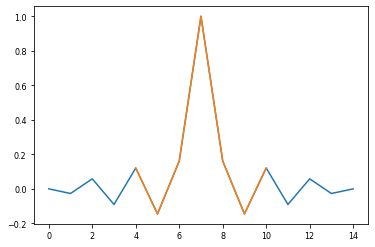

In [151]:
threshold=0.65
filt=sinc(15)
print(f'sinc({len(filt)}) = {np.round(filt,4)}')
DDfilt=np.convolve(filt,np.array([-1.,2.,-1.]),'same'); DDfilt=DDfilt[len(filt)//2:]; DDfilt[-2:]=0
if DDfilt[1:].max() > 0:
  DDfilt[DDfilt<0]=0.
else:
  DDfilt[:]=1.
Esym=np.cumsum(2*np.abs(filt[len(filt)//2:])); Esym-=filt[len(filt)//2]
Esym=(Esym/Esym[-1])
idx=np.argmax(np.logical_and(Esym >= threshold, DDfilt > 0))
idxUsemin=len(filt)//2-idx
idxUsemax=len(filt)//2+idx+1
print(f'Trimmed filter = {np.round(filt[idxUsemin:idxUsemax],4)}')
x=np.arange(len(filt))
plt.plot(x,filt,x[idxUsemin:idxUsemax],filt[idxUsemin:idxUsemax])

In [155]:
np.sin(np.pi/2)

1.0